In [1]:
import sys
dim=256
sys.path.append('/content/drive/My Drive/colab')
imagefilepath = "/content/drive/My Drive/colab/ML Vertex Images/{}x{}".format(dim,dim)
trainf = imagefilepath + "/train.zip"
testf = imagefilepath + "/test.zip"
valf = imagefilepath + "/val.zip"

In [2]:
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import numpy as np
from sklearn.utils import compute_class_weight
import pandas as pd
import time
import datetime
try:
  import splitfolders
except ImportError:
  !pip install split-folders[full]
try:
  from tensorflow.random import seed
except ImportError:
  !pip install tensorflow
from LLCNN_VertexImages_Utils import preprocess, significance, epoch_history, roc_plot
import os

#Unzip signal, background, train, test, and val folders
!cp '{trainf}' .
os.chdir('/content')
!unzip -q 'train.zip'
!cp '{testf}' .
os.chdir('/content')
!unzip -q 'test.zip'
!cp '{valf}' .
os.chdir('/content')
!unzip -q 'val.zip'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
### Author: Colby Thompson 11/4/2021
### Code designed to train LL Vertex Image data on a CNN

##############################################################
##                           CNN                            ##
##############################################################
#Set seed
np.random.seed(7) #Numpy

#Create train, test, and val image generators
batch_size = 8 #Number of training samples to use in each mini batch during gradient descent
image_generator = ImageDataGenerator()
train = image_generator.flow_from_directory('/content/train', target_size=(dim, dim), batch_size=batch_size, class_mode='binary', shuffle=False)
test = image_generator.flow_from_directory('/content/test', target_size=(dim, dim), batch_size=batch_size, class_mode='binary', shuffle=False)
val = image_generator.flow_from_directory('/content/val', target_size=(dim, dim), batch_size=batch_size, class_mode='binary', shuffle=False)

#Get total number of signal and background images
nsig = 0
for x in train.labels:
  if x == 1:
    nsig+=1
for x in test.labels:
  if x == 1:
    nsig+=1
for x in val.labels:
  if x == 1:
    nsig+=1 
nbkg = len(train.labels) + len(test.labels) + len(val.labels) - nsig
print("Number of signal images = {}\nNumber of background images = {}".format(nsig, nbkg))

Found 50690 images belonging to 2 classes.
Found 15840 images belonging to 2 classes.
Found 12672 images belonging to 2 classes.
Number of signal images = 39601
Number of background images = 39601


In [4]:
#Hyperparameters
testing_fraction = 0.2
filter_size = 3 #3x3 Convolutional filter
num_filters = 16
maxpool_size = 2 #2x2 Max pooling layer
dense_nodes = 100
dropout = 0.2 #Dropout value for training, helps reduce overfitting
train_steps_per_epoch = int(len(train)/batch_size)
val_steps_per_epoch = int(len(val)/batch_size)
epochs = 50
patience = 10
min_delta = 0.01

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 100)               6

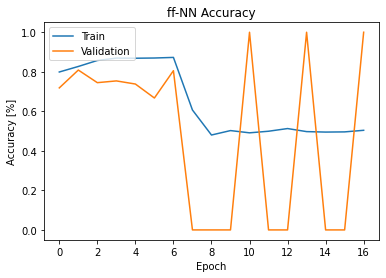

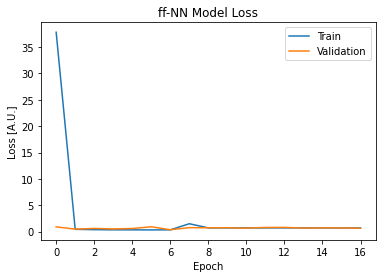

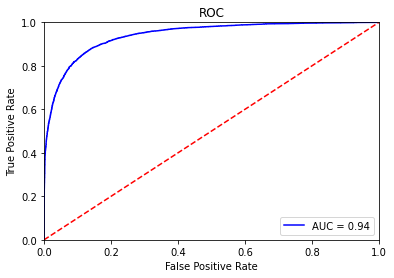

/content/drive/My Drive/colab/LLCNN_VertexImages_Utils.py:67: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_data).flatten()


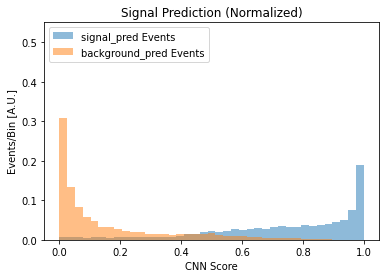

7920 7920
nSig = 6111.0 , nBkg = 525.0 with significance = 266.706 +/- 6.746 for CNN score > 0.566


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


In [5]:
#Start the timer
start_time = time.time()

#Create the CNN model
model = Sequential()
model.add(Conv2D(num_filters, (filter_size, filter_size), input_shape=(dim, dim, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(maxpool_size, maxpool_size)))
model.add(Conv2D(int(num_filters), (int(filter_size), int(filter_size)), activation='relu'))
model.add(MaxPooling2D(pool_size=(maxpool_size, maxpool_size)))
model.add(Flatten())
model.add(Dense(units=dense_nodes, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='sigmoid'))

#Compile and fit the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
modelcheckpoint_filepath = "/content/drive/My Drive/colab/Model Checkpoints/{}".format(datetime.datetime.now())
fit_callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience, min_delta=min_delta, restore_best_weights=True),
ModelCheckpoint(filepath=modelcheckpoint_filepath, monitor='val_loss', mode='min', verbose=0, save_best_only=True)]

history = model.fit(train, validation_data=val, steps_per_epoch=train_steps_per_epoch, validation_steps=val_steps_per_epoch,
                              epochs=epochs, verbose=2, callbacks=fit_callbacks)
#Finish train model timer
model_time = time.time() - start_time

#Evaluate the CNN's performance
print("--- Train model time %s seconds ---" % model_time)
score = model.evaluate(test)
for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))
epoch_history(history)
roc_plot(model, test, test.labels)

#Generate significance score
significance(model, test, test.labels, testing_fraction, nsig, nbkg, minBackground=500, logarithmic=False)

#Generate and save predictions for all vertices
pred_train = model.predict_generator(train)
pred_test = model.predict_generator(test)
pred_val = model.predict_generator(val)
pred_train_fixed = np.array(pred_train).flatten().round(3)
pred_test_fixed = np.array(pred_test).flatten().round(3)
pred_val_fixed = np.array(pred_val).flatten().round(3)
pred_train_df = pd.DataFrame({'Filename': train.filenames, 'CNN Predictions': pred_train_fixed, 'Labels': train.labels})
pred_test_df = pd.DataFrame({'Filename': test.filenames, 'CNN Predictions': pred_test_fixed, 'Labels': test.labels})
pred_val_df = pd.DataFrame({'Filename': val.filenames, 'CNN Predictions': pred_val_fixed, 'Labels': val.labels})
pred_train_df.to_csv("/content/drive/My Drive/colab/CNN Train Predictions.csv")
pred_test_df.to_csv("/content/drive/My Drive/colab/CNN Test Predictions.csv")
pred_val_df.to_csv("/content/drive/My Drive/colab/CNN Val Predictions.csv")